$$ q_j(t_n) = q_j(t_{n-1})* \mathrm{e}^{-\dfrac {\delta t}{\tau_j}} + (1 - \mathrm{e}^{-\dfrac {\delta t}{\tau_j}})* [\sum_{i=1}^{N_{inj}} f_{ij}I_k(t_k) - J_j\tau_j\dfrac {\Delta p_{wfj}}{\Delta t_k}] $$

$$ Constraint\ 1-  \; \sum_{j=1}^{N_{prd}} f_{ij} = 1 $$

$$\tau = \dfrac{c_tv_p}{j}$$

Here we have ignored pressure and considered $\tau$ = 1. Also code in run for one producer and relation with all injectors is found. For all producers same code can be run adding Constraint 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime

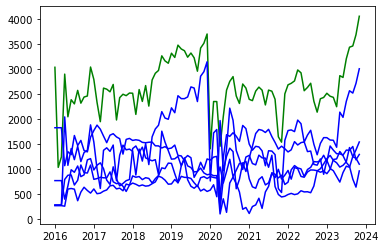

In [2]:
def parser(x):
	return datetime.strptime(x, '%m-%d-%Y')

prd = pd.read_csv('Production.csv', header=0, parse_dates=[0], date_parser=parser)
inj = pd.read_csv('Injection.csv', header=0, parse_dates=[0], date_parser=parser)

plt.plot(prd.iloc[:,0], prd.iloc[:,1], c='green')
for i in range(1,inj.shape[1]):
    plt.plot(inj.iloc[:,0], inj.iloc[:,i], c='blue')
plt.show()

In [3]:
inj_1 = inj.iloc[1:,:].copy()
inj_1.insert(1,'Prd(t)', prd.iloc[1:,1])
inj_1.insert(1,'Prd(t-1)', prd.iloc[:prd.shape[0]-1,1].to_numpy())

del_t = []
for i in range(1,prd.shape[0]):
    del_t.append((prd.iloc[i,0]-prd.iloc[i-1,0]).days)
   
inj_1.insert(1,'Det_T',np.array(del_t))
inj_1.head(5)

,Date,Det_T,Prd(t-1),Prd(t),I1,I2,I3,I4,I5
1,2016-02-01,31,3030.190674,1034.125977,284.674286,1824.665039,278.600098,270.062286,769.675415
2,2016-03-02,30,1034.125977,1242.952759,284.674286,1824.665039,278.600098,270.062286,769.675415
3,2016-04-02,31,1242.952759,2894.078125,2040.237061,1067.610962,792.954712,259.661194,400.257812
4,2016-05-02,30,2894.078125,2043.140869,1074.394043,1346.782959,876.539978,601.046997,663.333191
5,2016-06-02,31,2043.140869,2383.028564,1409.095947,1286.029053,882.775207,612.490906,986.206726


In [4]:
inj_1 = inj_1.to_numpy()

In [5]:
inj_1_train = inj_1[:70,:]
inj_1_test = inj_1[70:,:]

In [6]:
tau = 1

def pred(parameters, inj):
    f1=parameters[0]
    f2=parameters[1]
    f3=parameters[2]
    f4=parameters[3]
    f5=parameters[4]
    
    q_t = inj[:,2]*np.exp(-inj[:,1].astype(float)/tau)+ (1-np.exp(-inj[:,1].astype(float)/tau))*(f1*inj[:,4]+f2*inj[:,5]+f3*inj[:,6]+f4*inj[:,7]+f5*inj[:,8])
    return q_t

In [7]:
def fn(parameters):
    f1=parameters[0]
    f2=parameters[1]
    f3=parameters[2]
    f4=parameters[3]
    f5=parameters[4]
    
    q_t = inj_1_train[:,2]*np.exp(-inj_1_train[:,1].astype(float)/tau)+ (1-np.exp(-inj_1_train[:,1].astype(float)/tau))*(
          f1*inj_1_train[:,4]+f2*inj_1_train[:,5]+f3*inj_1_train[:,6]+f4*inj_1_train[:,7]+f5*inj_1_train[:,8])
    loss = sum((q_t - inj_1_train[:,3])**2)
    return loss

# def con(parameters):
    return 1- sum(parameters)

# cons = cons = {'type':'eq', 'fun': con}

# bnds = ((0, None),(0, None),(0, None),(0, None),(0, None))

In [8]:
model = minimize(fn,(0.1,0.1,0.1,0.1,0.1), method='SLSQP')
model

     fun: 333519.64628246176
     jac: array([-0.23828125, -2.00390625,  0.04296875,  0.67578125,  2.359375  ])
 message: 'Optimization terminated successfully'
    nfev: 80
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.98940641, 0.52922182, 0.19005834, 0.10594421, 0.08566242])

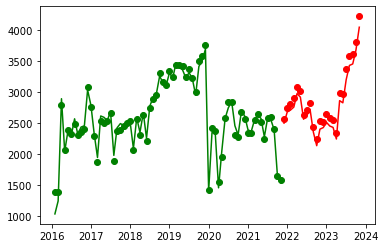

In [9]:
parameters = model.x

plt.scatter(inj_1_train[:,0], pred(parameters,inj_1_train), c='green')
plt.plot(inj_1_train[:,0],inj_1_train[:,3], c='green')
plt.scatter(inj_1_test[:,0], pred(parameters,inj_1_test), c='red')
plt.plot(inj_1_test[:,0],inj_1_test[:,3], c='red')